In [1]:
# For training
from keras.applications import VGG16
from keras import models, optimizers, layers
from keras.preprocessing.image import ImageDataGenerator
# Testing plugin
from livelossplot import PlotLossesKeras

C:\Users\Felipe\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
height = 100
width = 150
batch_size = 100
train_dir = 'ImagesForFlow/train/'
test_dir = 'ImagesForFlow/test/'

In [3]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))
vgg_conv.trainable = True
#print(len(vgg_conv.trainable_weights))
set_trainable = False
for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
#print(len(vgg_conv.trainable_weights))
#vgg_conv.summary()

In [4]:
model = models.Sequential()

model.add(vgg_conv)

#model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(163, activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(163, activation='softmax'))

#model.summary()

In [5]:
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

val_batchsize = int(batch_size / 10)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=val_batchsize,
    class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Found 109325 images belonging to 163 classes.
Found 27340 images belonging to 163 classes.


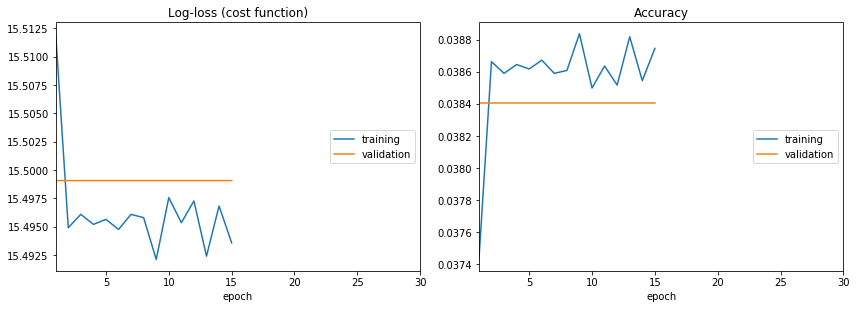

Epoch 16/30
1092/1093 [============================>.] - ETA: 3s - loss: 15.4939 - acc: 0.0387

KeyboardInterrupt: 

In [6]:
model.fit_generator(
    train_generator,
    steps_per_epoch=int(train_generator.samples / train_generator.batch_size),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=int(validation_generator.samples / validation_generator.batch_size),
    callbacks=[PlotLossesKeras()],
    verbose=1)

In [ ]:
model.save('Models/mark1.h5')